<a href="https://colab.research.google.com/github/theclosedbook/TensorFlow/blob/main/04_Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1 : Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.
There are two main benefits:

1. Can leverage an existing neural network arechitecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture whi9ch has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU
!nvidia-smi

Tue Feb 13 19:41:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Downlaod and become one with the data

In [2]:
# Get the data
import zipfile

# Downlaod the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-02-13 19:41:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2024-02-13 19:41:44 (174 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through the directories
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

### creating a dataloader (preparing the data)
We'll use `ImageDataGenerator` class to load in our images

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_precent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Data:")

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing Data:
Found 2500 images belonging to 10 classes.


### Setting up callbacks(things to run whilst our model train)

Callbacks are extra functionallity you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Training experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [5]:
# Create TensorBoard callback(functionized becasue we need to create a new one for each model)
import tensorflow as tf
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we have used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on:https://tfhub.dev/

In [6]:
# Lets compare the following two models

resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [7]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from URL

def create_model(model_url,num_classes=10):
  # Download a pretrained model and save as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # Freeze the already learned patterns

  # Create our own model
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax", name="output_layer")
  ])

  return model

## Creating and tetsing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create a Resnet model

resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_precent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [11]:
# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
# Fit our model
resnet_history = resnet_model.fit(train_data_10_precent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_precent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20240213-194156
Epoch 1/5
24/24 [==============================] - 23s 665ms/step - loss: 1.9175 - accuracy: 0.3613 - val_loss: 1.2155 - val_accuracy: 0.6032
Epoch 2/5
24/24 [==============================] - 12s 508ms/step - loss: 0.9055 - accuracy: 0.7147 - val_loss: 0.8553 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 10s 444ms/step - loss: 0.6174 - accuracy: 0.8213 - val_loss: 0.7483 - val_accuracy: 0.7520
Epoch 4/5
24/24 [==============================] - 11s 488ms/step - loss: 0.4739 - accuracy: 0.8760 - val_loss: 0.6969 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 11s 449ms/step - loss: 0.3804 - accuracy: 0.9107 - val_loss: 0.6747 - val_accuracy: 0.7736


In [16]:
# Create afunction for our loss curves

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs,loss,label='training loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accucracy")
  plt.plot(epochs , val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

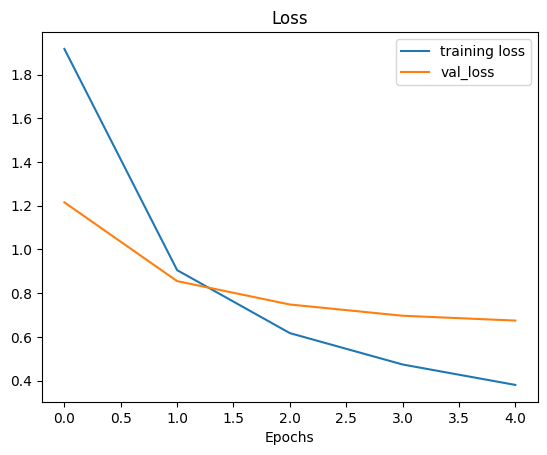

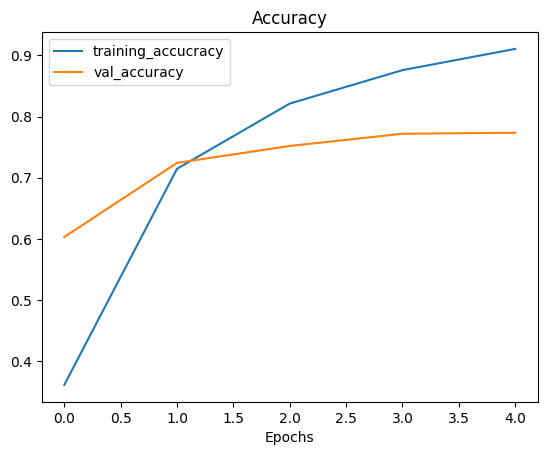

In [17]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientnetBO Tensorflow Hub Feature Extraction Mofrl

In [18]:
# Creating a EfficientNetBO Model
En_model = create_model(efficientnet_url,num_classes = train_data_10_precent.num_classes)

In [22]:
En_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [20]:
# COmpile the EN Model
En_model.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [27]:
# Fit the En model
En_history = En_model.fit(train_data_10_precent,
                          epochs=10,
                          steps_per_epoch=len(train_data_10_precent),
                          validation_data=test_data_10_percent,
                          validation_steps=len(test_data_10_percent),
                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="EfficientnetB0")])

Saving TensorBoard log files to : tensorflow_hub/EfficientnetB0/20240213-200431
Epoch 1/10
24/24 [==============================] - 12s 454ms/step - loss: 0.4393 - accuracy: 0.9040 - val_loss: 0.5085 - val_accuracy: 0.8732
Epoch 2/10
24/24 [==============================] - 10s 434ms/step - loss: 0.3849 - accuracy: 0.9240 - val_loss: 0.4829 - val_accuracy: 0.8740
Epoch 3/10
24/24 [==============================] - 13s 542ms/step - loss: 0.3432 - accuracy: 0.9360 - val_loss: 0.4663 - val_accuracy: 0.8752
Epoch 4/10
24/24 [==============================] - 13s 545ms/step - loss: 0.3091 - accuracy: 0.9507 - val_loss: 0.4502 - val_accuracy: 0.8768
Epoch 5/10
24/24 [==============================] - 11s 459ms/step - loss: 0.2772 - accuracy: 0.9600 - val_loss: 0.4359 - val_accuracy: 0.8764
Epoch 6/10
24/24 [==============================] - 13s 557ms/step - loss: 0.2521 - accuracy: 0.9667 - val_loss: 0.4270 - val_accuracy: 0.8792
Epoch 7/10
24/24 [==============================] - 11s 457ms/

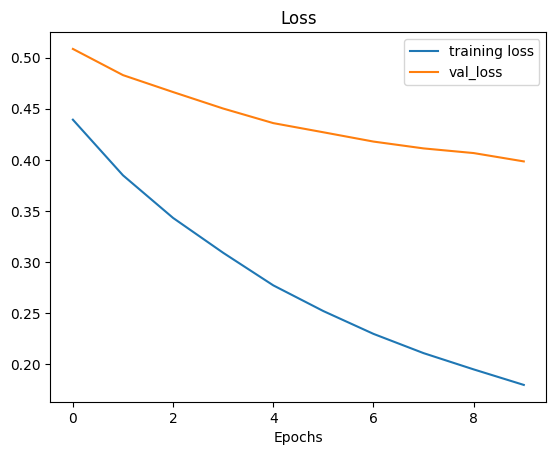

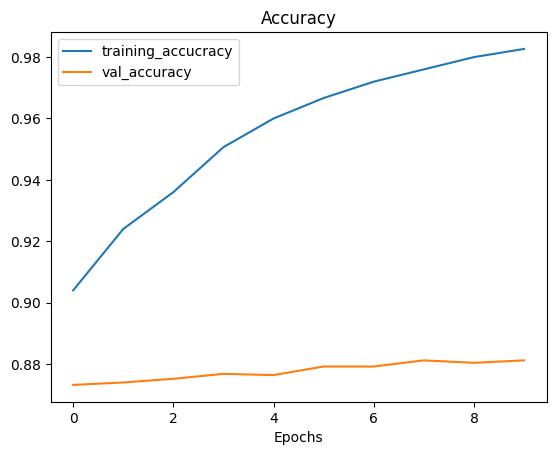

In [28]:
plot_loss_curves(En_history)

This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

    "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.

    For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).
        This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

    Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

    For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.
        This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

    Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.
        This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

    🤔 Question: Why train only the top 2-3 layers in feature extraction?

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).

In [31]:
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./content/tensorflow_hub/ \
  --name "EN vs ResNet" \
  --description " Comparing two models" \
  --one_shot

2024-02-13 20:22:08.950445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 20:22:08.950510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 20:22:08.952093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 20:22:10.339033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb